# Groups: 3D Virial Distance Properties Plots

### Importing Tables

In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt


import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import binned_statistic

import seaborn as sns

import statsmodels.api as sm

from scipy import stats

In [2]:
dwarf_table = Table.read('g_dwarf_table.txt', format = 'ascii.commented_header')
dwarf_table[:5]

aimc,IN_DR7_LSS,RA,DEC,Z,ELPETRO_ABSMAG_r,u_r,sSFR,HImass,flag3727,t3,Z12logOH,Zerr,logNO,NOerr,vflag_VF,ID,BPTclass,2D_neighbor_ID,2D_neighbor_dist,2D_neighbor_ID_vir,2D_neighbor_dist_vir,3D_neighbor_ID,3D_neighbor_dist,3D_neighbor_ID_vir,3D_neighbor_dist_vir,2D_group_ID,2D_group_dist,2D_group_ID_vir,2D_group_dist_vir,3D_group_ID,3D_group_dist,3D_group_ID_vir,3D_group_dist_vir
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,int32,float64,int32,float64,int32,float64,int32,float64,int32,float64,int32,float64,int32,float64,int32,float64
0.0,1.0,147.17645340393182,-0.3540349522432606,0.006282840855419636,-15.534673690795898,1.5979467332363129,-9.897252082824707,nan,nan,nan,nan,nan,nan,nan,2,12,1.0,49,0.18150554228021565,585714,1.3634632510011546,573,0.3210655024172438,208,2.3657856725525463,-1,nan,-1,nan,15644,41.4125128116787,2539,41.76447666154416
106.68,1.0,146.85676432411947,-0.27409664376066756,0.02196459472179413,-16.7003231048584,1.6220477223396301,-9.639364242553711,nan,nan,nan,nan,nan,nan,nan,2,31,1.0,79,0.6704515586457357,92,2.414294367856323,80,0.9556330809587631,585700,3.7385754919749274,4270,0.8122744988884393,4270,0.8348144901217259,4270,1.337840690743606,4270,1.3749647386881871
0.0,1.0,146.19277353258968,-0.6882589506846374,0.004080323036760092,-15.290872573852539,1.220979243516922,-9.548693656921387,nan,nan,nan,nan,nan,nan,nan,2,44,1.0,585695,0.035663331434249095,639857,0.46035331496314846,585695,0.221530846641702,585695,2.8927174640703734,-1,nan,-1,nan,15644,47.99876009341575,2539,48.37100908551739
199.39,1.0,146.00780426178756,-0.6422574964819474,0.004776299931108952,-15.831652641296387,0.7728094607591629,-7.982375621795654,nan,0.0,1.5717060395681055,7.73051787768279,0.0179600111522654,-0.5320566539047968,0.44255404846002694,2,45,1.0,585695,0.006393284307917346,585695,0.08348257342324528,639857,0.6010801341408164,639857,7.109919536505821,-1,nan,-1,nan,15644,45.91917727954949,2539,46.289567183583294
0.0,1.0,146.6190367018052,-0.43434631860351913,0.006036635022610426,-16.34455108642578,1.7559601366519928,-9.769034385681152,nan,nan,nan,nan,nan,nan,nan,2,49,1.0,585714,0.07059729101415332,585714,0.4172620229334301,585714,0.3596492056527832,585714,2.125689993784549,-1,nan,-1,nan,15644,42.14864050680927,2539,42.50789399533266


In [3]:
t3mask = dwarf_table['t3'] < 3  # Makes a boolean selection mask (numpy array)
dwarf_t3= dwarf_table[t3mask]

In [4]:
# Separating into Void, Wall, or Other Dwarf Galaxies

dwarf_wall = dwarf_table['vflag_VF']==0
dwarf_void = dwarf_table['vflag_VF']==1
dwarf_other = ~(dwarf_wall | dwarf_void)


dwarf_wall_t3 = dwarf_t3['vflag_VF']==0
dwarf_void_t3 = dwarf_t3['vflag_VF']==1
dwarf_other_t3 = ~(dwarf_wall_t3 | dwarf_void_t3)

## Profile Histogram Function

In [5]:
def profilehist(x, y, w=None, bins=10, uncertainty='stderr'):
    """Compute a profile histogram given x, y and optional weights.
    
    Parameters
    ----------
    x : (N,) array_like
        Sequence of values to be binned.
    y : (N,) array_like
        Data on which the statistic will be computed.
    w : None or (N,) array_like
        Weights for each data point y.
    bins : int or array_like
        If int, define equal-length bins given by data min/max range; else, user-defined bin edges.
    uncertainty : str
        'stderr' to compute standard error on the mean; 'sample' for sample uncertainty
        
    Returns
    -------
    xc : array of dtype float
        Bin centers in x.
    yavg : array of dtype float
        Average in each bin.
    yerr : array of dtype float
        Uncertainty in each bin (sample error or error on the mean).
    """
    # Default to equal weights in each bin.
    if w is None:
        w = np.ones_like(y, dtype=np.float64)

    # Compute weighted sums and construct the weighted means and uncertainties.
    (Y, E, W), edges, idx = binned_statistic(x, [w*y, w*y**2, w], bins=bins, statistic='sum')
    yavg = Y/W
    ystd = np.sqrt(E/W - yavg**2)
    yerr = ystd/np.sqrt(W)

    # Compute bin centers.
    xc = 0.5*(edges[1:] + edges[:-1])
    
    if uncertainty == 'sample':
        return xc, yavg, ystd
    elif uncertainty == 'stderr':
        return xc, yavg, yerr
    else:
        raise ValueError(f'uncertainty={uncertainty} unknown; allowed: "stderr" and "sample"')

# Z test function

In [6]:
from scipy.stats import norm

def zscore_pvalue(a1, a2, sig_a1, sig_a2):
    """Compute the p-value for a given z-score.
    
    The p-value tells you the probability of obtaining a1 and a2 assuming
    that the come from the same parent distribution. I.e., if a1 and a2
    sample the same distribution, this tells you the probability that you
    will observe a difference as large or larger than a1-a2, given the
    uncertainties sig_a1 and sig_a2.
    
    I.e., how likely is it that we'd observe a difference at least as
    large as a1-a2 solely by chance?
    
    Parameters
    ----------
    a1 : float
        Central value 1.
    a2 : float
        Central value 2.
    sig_a1 : float
        Uncertainty in central value 1.
    sig_a2 : float
        Uncertainty in central value 2.
        
    Returns
    -------
    z : float
        The z-score z = (a1-a2) / sqrt(sigma1_a1^2 + sigma_a2^2).
    p : float
        The p-value, or tail probability.
    """
    z = np.abs(a1 - a2) / np.sqrt(sig_a1**2 + sig_a2**2)
    # Computes two-tailed p-value. Should we do one-tailed?
    return z, 2*norm.sf(z)

# Profile Historgrams and Linear Regressions

## Color (u-r)


### Profile Histogram

In [7]:
sfd = dwarf_table['BPTclass'] == 1
sfd_t3 = dwarf_t3['BPTclass'] == 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


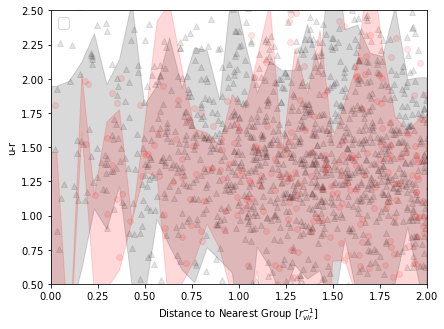

In [8]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    #d = dwarf_table['3D_group_dist_vir'][select & sfd]
    #vals = dwarf_table['u_r'][select & sfd]
    
    d = dwarf_table['3D_group_dist_vir'][select]
    vals = dwarf_table['u_r'][select]
    
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.linspace(0,2,31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.fill_between([0, *xc, 2], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Group [$r^{-1}_{vir}]$', ylabel='u-r', xlim=([0,2]), ylim=([0.5,2.5]));
    ax.legend();

    #fig.savefig('group_sfd_ur_3D_vir_PH.png')
    
    #fig.savefig('group_ur_3D_vir_PH.png')

### Linear Regression

(0.31866712053499935, 0.7499789497740436)
(0.8239793572450247, 0.409951287303146)


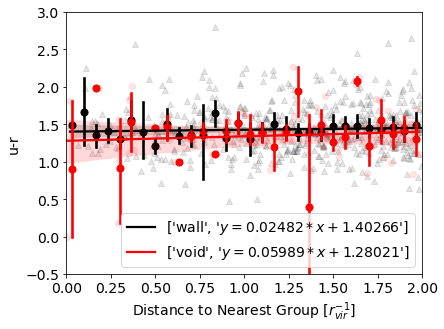

In [9]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d_all = dwarf_table['3D_group_dist_vir'][select & sfd]
    vals_all = dwarf_table['u_r'][select & sfd]
    
    #d_all = dwarf_table['3D_group_dist_vir'][select]
    #vals_all = dwarf_table['u_r'][select]
    
    mask = (d_all > 0) & (d_all <= 2)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
        
    xedges = np.linspace(0,2,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
    #slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, 
                #line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})      
     
    result = stats.linregress(d[nonan], vals[nonan])
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax,  
                line_kws={'label': [label, '$y=%3.7s*x+%3.7s$'%(result.slope, result.intercept)]})    
        
    ax.set(xlabel='Distance to Nearest Group [$r^{-1}_{vir}]$', ylabel='u-r', xlim=(0,2), ylim=(-0.5,3));
        
    ax.legend()
        
    #fig.savefig('group_sfd_ur_3D_vir_LR.png')
    
    #fig.savefig('group_ur_3D_vir_LR.png')
    
# Z test and P Value Calculation    
    
    if c == 'k': #condition that determines whether or not you're looking at the void or wall sample
        wall_slope = result.slope
        wall_slope_err = result.stderr
        wall_intercept = result.intercept
        wall_intercept_err = result.intercept_stderr
        
    else: # 
        void_slope = result.slope
        void_slope_err = result.stderr
        void_intercept = result.intercept
        void_intercept_err = result.intercept_stderr
    
ur_slope = zscore_pvalue(wall_slope, void_slope, wall_slope_err, void_slope_err)    
ur_intercept = zscore_pvalue(wall_intercept, void_intercept, wall_intercept_err, void_intercept_err) 

print(ur_slope)
print(ur_intercept) 

## Star Formation Rate (sSFR)

### Profile Histogram

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\caeho\AppData\Local\Temp\ipykernel_25960\2670135367.py:32: RuntimeWarning: invalid value encountered in true_divide
  yavg = Y/W
C:\Users\caeho\AppData\Local\Temp\ipykernel_25960\2670135367.py:33: RuntimeWarning: invalid value encountered in true_divide
  ystd = np.sqrt(E/W - yavg**2)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


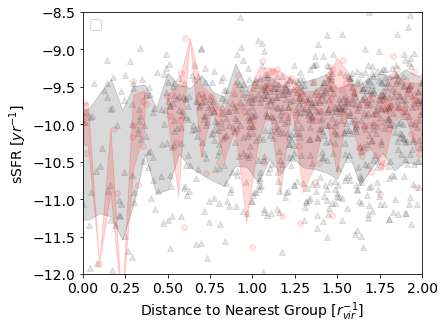

In [10]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    #d = dwarf_table['3D_group_dist_vir'][select & sfd]
    #vals = dwarf_table['sSFR'][select & sfd]
    
    d = dwarf_table['3D_group_dist_vir'][select]
    vals = dwarf_table['sSFR'][select]
    
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.linspace(0,2,31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.fill_between([0, *xc, 2], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Group [$r^{-1}_{vir}]$', ylabel='sSFR [$yr^{-1}]$', xlim=([0,2]), ylim=(-12,-8.5));
    ax.legend();

    #fig.savefig('group_sfd_sSFR_3D_vir_PH.png')
    
    #fig.savefig('group_sSFR_3D_vir_PH.png')

### Linear Regression

(0.49672877023366707, 0.6193803312352401)
(0.2438618761601157, 0.8073377963095557)


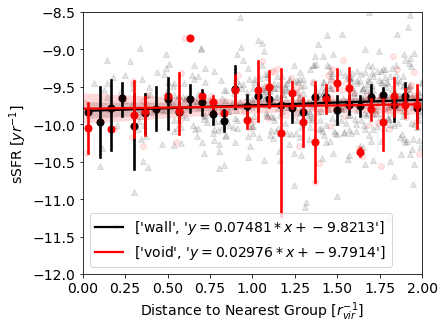

In [16]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d_all = dwarf_table['3D_group_dist_vir'][select & sfd]
    vals_all = dwarf_table['sSFR'][select & sfd]
    
    #d_all = dwarf_table['3D_group_dist_vir'][select]
    #vals_all = dwarf_table['sSFR'][select]
    
    mask = (d_all > 0) & (d_all <= 2)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
        
    xedges = np.linspace(0,2,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
    #slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, 
                #line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})     
    
    result = stats.linregress(d[nonan], vals[nonan])
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax,  
                line_kws={'label': [label, '$y=%3.7s*x+%3.7s$'%(result.slope, result.intercept)]})
    
    ax.set(xlabel='Distance to Nearest Group [$r^{-1}_{vir}]$', ylabel='sSFR [$yr^{-1}]$', xlim=(0,2), ylim=(-12,-8.5));
        
    ax.legend()
        
    #fig.savefig('group_sfd_sSFR_3D_vir_LR.png')
    #fig.savefig('group_sSFR_3D_vir_LR.png')
    
    
# Z test and P Value Calculation    
    
    if c == 'k': #condition that determines whether or not you're looking at the void or wall sample
        wall_slope = result.slope
        wall_slope_err = result.stderr
        wall_intercept = result.intercept
        wall_intercept_err = result.intercept_stderr
        
    else: # 
        void_slope = result.slope
        void_slope_err = result.stderr
        void_intercept = result.intercept
        void_intercept_err = result.intercept_stderr
    
sSFR_slope = zscore_pvalue(wall_slope, void_slope, wall_slope_err, void_slope_err)    
sSFR_intercept = zscore_pvalue(wall_intercept, void_intercept, wall_intercept_err, void_intercept_err) 

print(sSFR_slope)
print(sSFR_intercept)

## Metallicity (12 + log(O/H))

### Profile Histogram


C:\Users\caeho\AppData\Local\Temp\ipykernel_25960\2670135367.py:32: RuntimeWarning: invalid value encountered in true_divide
  yavg = Y/W
C:\Users\caeho\AppData\Local\Temp\ipykernel_25960\2670135367.py:33: RuntimeWarning: invalid value encountered in true_divide
  ystd = np.sqrt(E/W - yavg**2)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


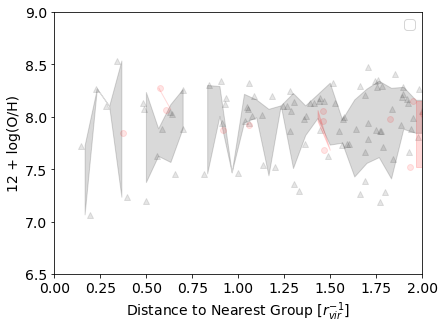

In [12]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    #d = dwarf_t3['3D_group_dist_vir'][select & sfd_t3]
    #vals = dwarf_t3['Z12logOH'][select & sfd_t3]
    
    d = dwarf_t3['3D_group_dist_vir'][select]
    vals = dwarf_t3['Z12logOH'][select]
    
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.linspace(0,2,31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.fill_between([0, *xc, 2], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Group [$r^{-1}_{vir}]$', ylabel='12 + log(O/H)', xlim=([0,2]), ylim=(6.5,9));
    ax.legend();

    #fig.savefig('group_sfd_Z12logOH_3D_vir_PH.png')
    
    #fig.savefig('group_Z12logOH_3D_vir_PH.png')

### Linear Regression


(1.3053177003080232, 0.1917846893306756)
(1.2143134713288126, 0.22462804334826092)


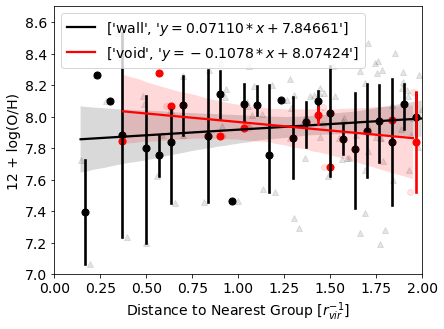

In [17]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    #d_all = dwarf_t3['3D_group_dist_vir_h_2'][select & sfd_t3]
    #vals_all = dwarf_t3['Z12logOH'][select & sfd_t3]
    
    d_all = dwarf_t3['3D_group_dist_vir'][select]
    vals_all = dwarf_t3['Z12logOH'][select]
    
    mask = (d_all > 0) & (d_all <= 2)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
        
    xedges = np.linspace(0,2,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
    #slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, 
                #line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})     
     
    result = stats.linregress(d[nonan], vals[nonan])
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax,  
                line_kws={'label': [label, '$y=%3.7s*x+%3.7s$'%(result.slope, result.intercept)]})    
        
    ax.set(xlabel='Distance to Nearest Group [$r^{-1}_{vir}]$', ylabel='12 + log(O/H)', xlim=(0,2), ylim=(7,8.7));
        
    ax.legend()
        
    #fig.savefig('group_sfd_Z12logOH_3D_vir_LR.png')
    
    #fig.savefig('group_Z12logOH_3D_vir_LR.png')
    
    
# Z test and P Value Calculation    
    
    if c == 'k': #condition that determines whether or not you're looking at the void or wall sample
        wall_slope = result.slope
        wall_slope_err = result.stderr
        wall_intercept = result.intercept
        wall_intercept_err = result.intercept_stderr
        
    else: # 
        void_slope = result.slope
        void_slope_err = result.stderr
        void_intercept = result.intercept
        void_intercept_err = result.intercept_stderr
    
Z12logOH_slope = zscore_pvalue(wall_slope, void_slope, wall_slope_err, void_slope_err)    
Z12logOH_intercept = zscore_pvalue(wall_intercept, void_intercept, wall_intercept_err, void_intercept_err) 

print(Z12logOH_slope)
print(Z12logOH_intercept)

## N/O Ratio

### Profile Histogram

C:\Users\caeho\AppData\Local\Temp\ipykernel_25960\2670135367.py:32: RuntimeWarning: invalid value encountered in true_divide
  yavg = Y/W
C:\Users\caeho\AppData\Local\Temp\ipykernel_25960\2670135367.py:33: RuntimeWarning: invalid value encountered in true_divide
  ystd = np.sqrt(E/W - yavg**2)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


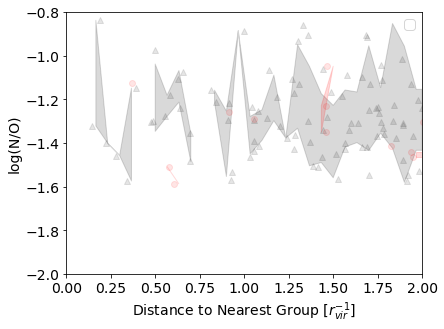

In [14]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    #d = dwarf_t3['3D_group_dist_vir'][select & sfd_t3]
    #vals = dwarf_t3['logNO'][select & sfd_t3]
    
    d = dwarf_t3['3D_group_dist_vir'][select]
    vals = dwarf_t3['logNO'][select]
    
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.linspace(0,2,31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.fill_between([0, *xc, 2], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Group [$r^{-1}_{vir}]$', ylabel='log(N/O)', xlim=([0,2]), ylim=(-2,-0.8));
    ax.legend();

    #fig.savefig('group_sfd_logNO_3D_vir_PH.png')
    #fig.savefig('group_logNO_3D_vir_PH.png')


### Linear Regression

(0.2663696100795699, 0.7899545676410149)
(0.29031802767335774, 0.7715729483876942)


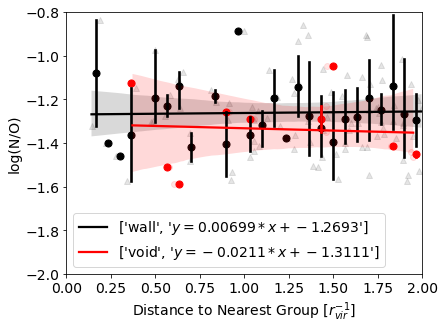

In [18]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    #d_all = dwarf_t3['3D_group_dist_vir'][select & sfd_t3]
    #vals_all = dwarf_t3['logNO'][select & sfd_t3]
    
    d_all = dwarf_t3['3D_group_dist_vir'][select]
    vals_all = dwarf_t3['logNO'][select]
    
    mask = (d_all > 0) & (d_all <= 2)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
        
    xedges = np.linspace(0,2,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
    #slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, 
                #line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})     
        
    result = stats.linregress(d[nonan], vals[nonan])
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax,  
                line_kws={'label': [label, '$y=%3.7s*x+%3.7s$'%(result.slope, result.intercept)]})    
        
    ax.set(xlabel='Distance to Nearest Group [$r^{-1}_{vir}]$', ylabel='log(N/O)', xlim=(0,2), ylim=(-2,-0.8));
        
    ax.legend()
    
# Z test and P Value Calculation    
    
    if c == 'k': #condition that determines whether or not you're looking at the void or wall sample
        wall_slope = result.slope
        wall_slope_err = result.stderr
        wall_intercept = result.intercept
        wall_intercept_err = result.intercept_stderr
        
    else: # 
        void_slope = result.slope
        void_slope_err = result.stderr
        void_intercept = result.intercept
        void_intercept_err = result.intercept_stderr
    
logNO_slope = zscore_pvalue(wall_slope, void_slope, wall_slope_err, void_slope_err)    
logNO_intercept = zscore_pvalue(wall_intercept, void_intercept, wall_intercept_err, void_intercept_err) 

print(logNO_slope)
print(logNO_intercept) 
        
    #fig.savefig('group_sfd_logNO_3D_vir_LR.png')
    #fig.savefig('group_logNO_3D_vir_LR.png')